In [1]:
import os 
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from classifier import MLP, train 
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

sys.path.append(".")
# sys.path

In [2]:
# Load dataset
df = pd.read_csv('../AAPL_technical_analysis.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Define threshold values
up_threshold = 0.01  # 1% increase
down_threshold = -0.01  # 1% decrease

# Calculate percentage change in close price
df['close_pct_change'] = df['close'].pct_change()

# Create classification function
def classify_direction(pct_change):
    if pd.isna(pct_change):
        return np.nan  # Use NaN instead of None
    elif pct_change >= up_threshold:
        return 0  # Up
    elif pct_change <= down_threshold:
        return 1  # Down
    else:
        return 2  # Hold

# Apply classification function
df['price_direction'] = df['close_pct_change'].apply(classify_direction)

# Drop the first row (since pct_change introduces NaN)
df = df.iloc[1:]

# Drop remaining NaN values
df.dropna(subset=['price_direction'], inplace=True)

# Drop temporary column
df.drop('close_pct_change', axis=1, inplace=True)

# Show first few rows
# print(df[['close', 'price_direction']].head())
display(df)

,open,high,low,close,volume,High-Low,High-Close,Low-Close,True Range,ATR,...,DX,ADX,OBV,RSI,EMA_12,EMA_26,MACD,Signal_Line,MACD_Histogram,price_direction
Date,,,,,,,,,,,,,,,,,,,,,
1999-11-03,81.62,83.25,81.0000,81.50,2932700,2.2500,3.00,0.7500,3.0000,3.367449,...,100.000000,100.000000,4010000,100.000000,78.559290,78.087791,0.471498,0.127868,0.343631,0.0
1999-11-04,82.06,85.37,80.6200,83.62,3384700,4.7500,3.87,0.8800,4.7500,3.466203,...,100.000000,100.000000,7394700,100.000000,79.337861,78.497585,0.840276,0.270349,0.569927,0.0
1999-11-05,84.62,88.37,84.0000,88.31,3721500,4.3700,4.75,0.3800,4.7500,3.557902,...,100.000000,100.000000,11116200,100.000000,80.718190,79.224430,1.493760,0.515031,0.978728,0.0
1999-11-08,87.75,97.73,86.7500,96.37,8490400,10.9800,9.42,1.5600,10.9800,4.088052,...,100.000000,100.000000,19606600,100.000000,83.126161,80.494472,2.631688,0.938363,1.693325,0.0
1999-11-09,94.37,94.50,88.0000,89.62,7224800,6.5000,1.87,8.3700,8.3700,4.393906,...,100.000000,100.000000,12381800,73.529412,84.125213,81.170437,2.954775,1.341645,1.613130,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14,241.25,245.55,240.9900,244.60,40896227,4.5600,4.02,0.5400,4.5600,6.089485,...,30.536939,18.418021,-2518912928,64.955357,235.511931,235.465421,0.046510,-1.669417,1.715927,0.0
2025-02-18,244.15,245.18,241.8400,244.47,48822491,3.3400,0.58,2.7600,3.3400,5.893093,...,30.536939,19.283658,-2567735419,57.571324,236.890096,236.132427,0.757669,-1.184000,1.941669,2.0
2025-02-19,244.66,246.01,243.1604,244.87,32204215,2.8496,1.54,1.3096,2.8496,5.675701,...,32.085139,20.198050,-2535531204,56.834532,238.117773,236.779655,1.338119,-0.679576,2.017695,2.0


In [3]:



n_test = 30  # Use last 30 dates for inference

df_train = df.iloc[int(365*16):-n_test]  # Training data
df_test = df.iloc[-n_test:]   # Testing data

feature_cols = df.columns.tolist()
feature_cols.remove("price_direction")  # Ensure features do not contain target
input_dim = len(feature_cols)  

# Convert to PyTorch tensors
X_train = torch.tensor(df_train[feature_cols].values, dtype=torch.float32)
y_train = torch.tensor(df_train["price_direction"].values, dtype=torch.long)  # integer class labels (not one-hot)

X_test = torch.tensor(df_test[feature_cols].values, dtype=torch.float32)
y_test = torch.tensor(df_test["price_direction"].values, dtype=torch.long)  # integer class labels

# y_train into one-hot encoding 
y_train_one_hot = torch.nn.functional.one_hot(y_train, num_classes=3).float()

# Check for nans and replace them
X_train = torch.nan_to_num(X_train)
X_test = torch.nan_to_num(X_test)

print(X_train.shape)
print(y_train.shape)

torch.Size([494, 25])
torch.Size([494])


In [4]:

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)  # Use integer class labels, not one-hot
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# model parameters
output_dim = 3  
dropout_probs = [0.3, 0.8, 0.7]

model = MLP(input_dim, output_dim, dropout_probs)

# Fix class imbalance
# Compute class frequencies
class_counts = df['price_direction'].value_counts().sort_index().to_numpy()
class_weights = torch.tensor(1.0 / (class_counts + 1e-6), dtype=torch.float32)  # Avoid division by zero
class_weights /= class_weights.sum()  # Normalize so they sum to 1
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.01)

train(model, train_dataloader, criterion, optimizer, num_epochs=20)

model.eval()

logits, probs = model(X_test)  # Logits & softmax probabilities
predicted_class = torch.argmax(probs, dim=1)  # Convert softmax outputs to class predictions

print("Predicted Classes on Last", n_test, "Dates:\n", predicted_class)

mc_samples = model.forward_mc(X_test, mc_samples=500)
mc_pred = torch.argmax(mc_samples.mean(dim=0), dim=1)  # Convert mean MC samples to class index

print("\nMC DP Predicted samples:\n", mc_samples[0])
print("\nMC DP Predicted Classes:\n", mc_pred)

Epoch [1/20], Loss: 45304980.8672
Epoch [2/20], Loss: 127250.2463
Epoch [3/20], Loss: 16191.3803
Epoch [4/20], Loss: 8343.7975
Epoch [5/20], Loss: 1.0503
Epoch [6/20], Loss: 26156.7296
Epoch [7/20], Loss: 1.0388
Epoch [8/20], Loss: 1.0376
Epoch [9/20], Loss: 1.0471
Epoch [10/20], Loss: 1189.8836
Epoch [11/20], Loss: 1.0360
Epoch [12/20], Loss: 1.0417
Epoch [13/20], Loss: 1.0443
Epoch [14/20], Loss: 1.0354
Epoch [15/20], Loss: 1.0418
Epoch [16/20], Loss: 1.0378
Epoch [17/20], Loss: 72.1565
Epoch [18/20], Loss: 1.0442
Epoch [19/20], Loss: 1.0432
Epoch [20/20], Loss: 1.0402
Predicted Classes on Last 30 Dates:
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

MC DP Predicted samples:
 tensor([[0.2571, 0.2429, 0.5000],
        [0.2674, 0.2332, 0.4994],
        [0.2741, 0.2498, 0.4761],
        [0.2911, 0.2283, 0.4805],
        [0.2523, 0.2248, 0.5229],
        [0.2753, 0.2197, 0.5051],
        [0.2784, 0.2339, 0.4877],
        [0.27

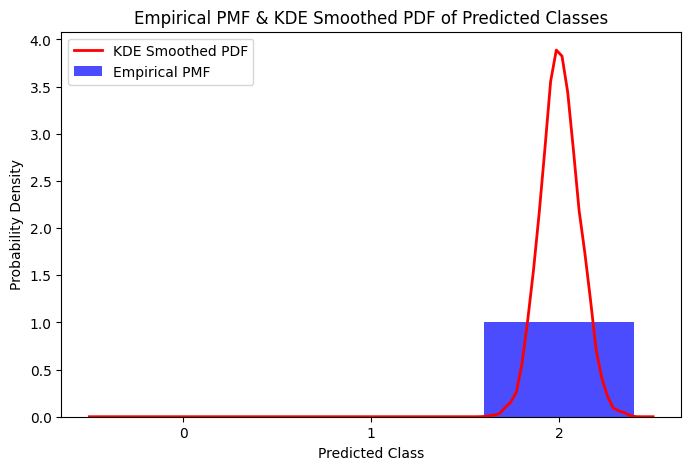

In [5]:

# Convert predictions to numpy (if using PyTorch tensor)
mc_pred_np = mc_pred.cpu().numpy()

# Compute empirical PMF
unique_classes, counts = np.unique(mc_pred_np, return_counts=True)
all_classes = np.array([0, 1, 2])  # Define all possible classes
counts_dict = dict(zip(unique_classes, counts))  # Create mapping of existing counts
counts_fixed = np.array([counts_dict.get(cls, 0) for cls in all_classes])  # Fill missing classes with 0

# Normalize probabilities for PMF
probs = counts_fixed / counts_fixed.sum() if counts_fixed.sum() > 0 else np.zeros(3)

# Generate synthetic samples based on the PMF (for KDE fitting)
samples = np.repeat(all_classes, (probs * 1000).astype(int))  # Weighted sampling

# Add small jitter (Gaussian noise) to avoid singular covariance matrix
samples = samples + np.random.normal(scale=0.1, size=samples.shape)

# Apply Kernel Density Estimation (KDE)
kde_2 = gaussian_kde(samples, bw_method='scott')
x_range = np.linspace(-0.5, 2.5, 100)  # Define a continuous range
pdf_values = kde_2(x_range)  # Compute PDF values

# Normalize to ensure area under PDF is 1
pdf_values /= np.trapz(pdf_values, x_range)

# Convert to PyTorch tensor
pdf_distribution = torch.tensor(pdf_values, dtype=torch.float32)

# Plot PMF (Bar Plot) & KDE (Line Plot)
plt.figure(figsize=(8, 5))

# Bar plot for PMF
plt.bar(all_classes, probs, color="blue", alpha=0.7, label="Empirical PMF")

# KDE plot
plt.plot(x_range, pdf_values, color="red", linewidth=2, label="KDE Smoothed PDF")

# Labels & Legends
plt.xticks(all_classes)
plt.xlabel("Predicted Class")
plt.ylabel("Probability Density")
plt.title("Empirical PMF & KDE Smoothed PDF of Predicted Classes")
plt.legend()
plt.show()
